In [1]:
#!pip install universal_pathlib

In [2]:
import joblib
import numpy as np
import pandas as pd
from upath import UPath as Path

from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from sklearn.preprocessing import scale

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
files_dir = Path("/Users/ewheeler/dev/UNDatathon/data/gdelt_files/")

In [5]:
def make_country_name_mapper(location_column_name, extra_from=None):
    # TODO caller needs a way to find out what `location_column_names` are possible
    # and/or we should match shorthands like
    # {'unicef': 'UNICEFOU', 'iso3': 'ISO3 (geonames)'}
    territory_identifiers = pd.read_csv(files_dir / "country-codes/country_codes.csv")

    class CountryNameMapper:
        # TODO add docstring
        def __init__(self, location_column_name, codes, extra_from):
            self.map = dict()
            self.codes = codes
        
            # these columns have country name strings in various formats
            ccode_name_cols = ['Country or Area_en (M49)', 'English Short (unterm)',
                               'English Formal (unterm)', 'name_short (exio-wiod-eora)',
                               'name_official (exio-wiod-eora)', 'Short name (fao)',
                               'Official name (fao)', 'Country (geonames)']
            if extra_from is not None:
                for extra in extra_from:
                    ccode_name_cols.append(extra)

            # make mapping of all various country name formats to desired location_column_name contents
            for country_name_col in ccode_name_cols:
                self.map.update(dict(self.codes[[country_name_col, location_column_name]].dropna().values))
            print(len(self.map.keys()))
        
        def __call__(self, location_name):
            # TODO might want to return the original location_name if not matched.
            # should make_location_name_mapper take some kind of 'missing value handler' parameter?
            return self.map.get(location_name, pd.NA)
        
    return CountryNameMapper(location_column_name, territory_identifiers, extra_from)

In [6]:
iso3_mapper = make_country_name_mapper('ISO3 (geonames)', extra_from=['fips (geonames)', 'M49 Code (M49)'])

1141


In [7]:
territory_identifiers = pd.read_csv(files_dir / "country-codes/country_codes.csv")

In [8]:
#territory_identifiers.columns.values

In [9]:
df_iso_fips = territory_identifiers[['ISO3 (geonames)', 'fips (geonames)']].dropna()
iso_fips_map = dict(zip(df_iso_fips['ISO3 (geonames)'].values, df_iso_fips['fips (geonames)'].values))

In [10]:
df_m49_iso = territory_identifiers[['M49 Code (M49)', 'ISO3 (geonames)']].dropna()
m49_iso_map = dict(zip(df_m49_iso['M49 Code (M49)'].astype(int).values, df_m49_iso['ISO3 (geonames)'].values))
m49_iso_map[729]

'SDN'

In [11]:
target_countries_iso = ['UKR', 'DJI', 'EGY', 'KEN', 'MOZ', 'SDN', 'TZA', 'RUS']

In [12]:
target_countries_fips = [iso_fips_map[c] for c in target_countries_iso]
target_countries_fips

['UP', 'DJ', 'EG', 'KE', 'MZ', 'SU', 'TZ', 'RS']

In [13]:
gdelt_query = 'food'

In [14]:
datasets = list(files_dir.glob(f'*{gdelt_query}*.feather'))
datasets

[PosixPath('/Users/ewheeler/dev/UNDatathon/data/gdelt_files/gdelt_food_timelinetone.feather'),
 PosixPath('/Users/ewheeler/dev/UNDatathon/data/gdelt_files/gdelt_food_timelinevol.feather'),
 PosixPath('/Users/ewheeler/dev/UNDatathon/data/gdelt_files/gdelt_food_artlist.feather'),
 PosixPath('/Users/ewheeler/dev/UNDatathon/data/gdelt_files/gdelt_food_timelinevolraw.feather')]

In [15]:
_df_tone = pd.read_feather(datasets[0])
_df_tone

,Date,Series,Value,fips,query,api_mode
0,2020-01-01,Average Tone,0.9926,CV,food,timelinetone
1,2020-01-02,Average Tone,-3.3071,CV,food,timelinetone
2,2020-01-03,Average Tone,0.0000,CV,food,timelinetone
3,2020-01-04,Average Tone,0.0000,CV,food,timelinetone
4,2020-01-05,Average Tone,0.0000,CV,food,timelinetone
...,...,...,...,...,...,...
360,2019-12-27,Average Tone,-2.5078,MZ,food,timelinetone
361,2019-12-28,Average Tone,0.0000,MZ,food,timelinetone
362,2019-12-29,Average Tone,0.0000,MZ,food,timelinetone
363,2019-12-30,Average Tone,0.0000,MZ,food,timelinetone


In [16]:
_df_vol = pd.read_feather(datasets[1])
_df_vol

,Date,Series,Value,fips,query,api_mode
0,2019-01-01,Volume Intensity,0.0121,SF,food,timelinevol
1,2019-01-02,Volume Intensity,0.0128,SF,food,timelinevol
2,2019-01-03,Volume Intensity,0.0098,SF,food,timelinevol
3,2019-01-04,Volume Intensity,0.0098,SF,food,timelinevol
4,2019-01-05,Volume Intensity,0.0105,SF,food,timelinevol
...,...,...,...,...,...,...
1393,2023-10-27,Volume Intensity,0.0023,SU,food,timelinevol
1394,2023-10-28,Volume Intensity,0.0014,SU,food,timelinevol
1395,2023-10-29,Volume Intensity,0.0054,SU,food,timelinevol
1396,2023-10-30,Volume Intensity,0.0038,SU,food,timelinevol


In [17]:
_df_art = pd.read_feather(datasets[2])
_df_art

,URL,MobileURL,Date,Title,fips,query,api_mode
0,https://lapagina.com.sv/nacionales/impulsan-la...,None,2023-08-09 23:45:00,Impulsan la inocuidad alimentaria con el progr...,ES,food,artlist
1,https://lapagina.com.sv/nacionales/anuncian-la...,None,2023-09-07 20:30:00,Anuncian la construcción de la primera central...,ES,food,artlist
2,https://lapagina.com.sv/nacionales/asamblea-ap...,None,2023-08-24 19:15:00,Asamblea aprueba que Policías continúen recibi...,ES,food,artlist
3,https://lapagina.com.sv/nacionales/fosalud-org...,None,2023-08-17 15:45:00,Fosalud organiza actividades para difundir la ...,ES,food,artlist
4,https://lapagina.com.sv/nacionales/pescadores-...,None,2023-09-15 17:15:00,Pescadores de Usulután reciben insumos y paque...,ES,food,artlist
...,...,...,...,...,...,...,...
5,http://www.alwatwan.net/economie/premi%C3%A8re...,None,2023-09-13 07:00:00,Premières journées scientifiques de lInrape I ...,CN,food,artlist
6,http://www.alwatwan.net/societe/coupures-d%E2%...,None,2023-10-13 04:45:00,Coupures d électricité à Ngazidja I Des entre...,CN,food,artlist
7,http://www.alwatwan.net/politique/78%C3%A8me-a...,None,2023-09-22 06:15:00,78ème Assemblée Générale des Nations Unies I L...,CN,food,artlist
0,https://www.gov.ms/2023/09/20/post-cabinet-pre...,None,2023-09-20 23:00:00,POST CABINET PRESS NOTES FOR 14TH SEPTEMBER 2023,MH,food,artlist


In [18]:
_df_volraw = pd.read_feather(datasets[3])
_df_volraw

,Date,Series,Value,fips,query,api_mode
0,2019-01-01,Article Count,0.0,BY,food,timelinevolraw
1,2019-01-01,Total Monitored Articles,297788.0,BY,food,timelinevolraw
2,2019-01-02,Article Count,0.0,BY,food,timelinevolraw
3,2019-01-02,Total Monitored Articles,446886.0,BY,food,timelinevolraw
4,2019-01-03,Article Count,1.0,BY,food,timelinevolraw
...,...,...,...,...,...,...
2791,2023-10-29,Total Monitored Articles,110515.0,NP,food,timelinevolraw
2792,2023-10-30,Article Count,12.0,NP,food,timelinevolraw
2793,2023-10-30,Total Monitored Articles,129977.0,NP,food,timelinevolraw
2794,2023-10-31,Article Count,35.0,NP,food,timelinevolraw


In [54]:
_df_fp = pd.read_csv(files_dir / 'Fao_dataset_2018_2023_EA_RUS_UKR_EGY.csv')
_df_fp

,Domain Code,Domain,Area Code (M49),Area,Year Code,Year,Item Code,Item,Months Code,Months,Element Code,Element,Unit,Value,Flag,Flag Description,Note
0,CP,Consumer Price Indices,108,Burundi,2018,2018,23013,"Consumer Prices, Food Indices (2015 = 100)",7001,January,6125,Value,Index,126.866284,X,Figure from international organizations,base year is 2015
1,CP,Consumer Price Indices,108,Burundi,2018,2018,23013,"Consumer Prices, Food Indices (2015 = 100)",7002,February,6125,Value,Index,124.250485,X,Figure from international organizations,base year is 2015
2,CP,Consumer Price Indices,108,Burundi,2018,2018,23013,"Consumer Prices, Food Indices (2015 = 100)",7003,March,6125,Value,Index,122.179643,X,Figure from international organizations,base year is 2015
3,CP,Consumer Price Indices,108,Burundi,2018,2018,23013,"Consumer Prices, Food Indices (2015 = 100)",7004,April,6125,Value,Index,122.724601,X,Figure from international organizations,base year is 2015
4,CP,Consumer Price Indices,108,Burundi,2018,2018,23013,"Consumer Prices, Food Indices (2015 = 100)",7005,May,6125,Value,Index,124.141493,X,Figure from international organizations,base year is 2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4153,CP,Consumer Price Indices,716,Zimbabwe,2023,2023,23014,Food price inflation,7002,February,6121,Value,%,136.853386,E,Estimated value,NaN
4154,CP,Consumer Price Indices,716,Zimbabwe,2023,2023,23014,Food price inflation,7003,March,6121,Value,%,127.921669,E,Estimated value,NaN
4155,CP,Consumer Price Indices,716,Zimbabwe,2023,2023,23014,Food price inflation,7004,April,6121,Value,%,101.645424,E,Estimated value,NaN
4156,CP,Consumer Price Indices,716,Zimbabwe,2023,2023,23014,Food price inflation,7005,May,6121,Value,%,116.962939,E,Estimated value,NaN


In [55]:
#_df_ac = pd.read_csv(files_dir / "ACLED_export.csv")

In [56]:
#_df_ac[['ACLED Year', 'TimeFK Event Date', 'Country FK', 'ACLED Fatalities']]

In [57]:
def mutate_vol_df(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.index = df['Date']
    df['iso3'] = df['fips'].map(iso3_mapper)
    df['Value_scaled'] = df.groupby('iso3')['Value'].transform(lambda x: scale(x))
    
    df_vol = df.groupby(['query', 'iso3', pd.Grouper(freq='M')]).sum(numeric_only=True).reset_index()
    df_vol['Date'] = df_vol['Date'].dt.normalize().map(lambda x : x.replace(day=1))
    df_vol = df_vol.rename(columns={'Value': 'timelinevol_orig', 'Value_scaled': 'timelinevol'})
    df_vol = df_vol.drop(columns=['query'])
    return df_vol

In [58]:
def mutate_tone_df(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.index = df['Date']
    df['iso3'] = df['fips'].map(iso3_mapper)
    df['Value_scaled'] = df.groupby('iso3')['Value'].transform(lambda x: scale(x))

    df_tone = df.groupby(['query', 'iso3', pd.Grouper(freq='M')]).sum(numeric_only=True).reset_index()
    df_tone['Date'] = df_tone['Date'].dt.normalize().map(lambda x : x.replace(day=1))
    df_tone = df_tone.rename(columns={'Value': 'timelinetone_orig', 'Value_scaled': 'timelinetone'})
    df_tone = df_tone.drop(columns=['query'])
    return df_tone

In [59]:
def mutate_fpi_df(df):
    df = df[df['Item'] == 'Food price inflation']
    df_fp = df[['Year', 'Months', 'Area Code (M49)', 'Area', 'Value']]
    df_fp['Date'] = pd.to_datetime(df_fp['Year'].astype(str) + ' ' + df_fp['Months']).dt.normalize()
    df_fp['fpi_orig'] = df_fp['Value'].astype(float)
    df_fp['iso3'] = df_fp['Area Code (M49)'].astype(int).map(m49_iso_map)
    df_fp['fpi'] = df_fp.groupby('iso3')['fpi_orig'].transform(lambda x: scale(x))

    return df_fp[['Date', 'iso3', 'fpi', 'fpi_orig']]

In [60]:
df_fp = mutate_fpi_df(_df_fp)

In [61]:
df_vol = mutate_vol_df(_df_vol)
df_tone = mutate_tone_df(_df_tone)

In [62]:
df_vol

,iso3,Date,timelinevol_orig,timelinevol
0,ABW,2019-01-01,0.0000,-1.579943
1,ABW,2019-02-01,0.0000,-1.427045
2,ABW,2019-03-01,0.0002,12.243576
3,ABW,2019-04-01,0.0002,12.294542
4,ABW,2019-05-01,0.0000,-1.579943
...,...,...,...,...
11353,ZWE,2023-06-01,0.2061,9.307748
11354,ZWE,2023-07-01,0.2399,19.276531
11355,ZWE,2023-08-01,0.2346,17.375670
11356,ZWE,2023-09-01,0.2097,10.598898


In [63]:
df_tone

,iso3,Date,timelinetone_orig,timelinetone
0,ABW,2019-01-01,0.0000,0.075283
1,ABW,2019-02-01,0.0000,0.067998
2,ABW,2019-03-01,4.1783,17.745218
3,ABW,2019-04-01,1.5000,6.416320
4,ABW,2019-05-01,0.0000,0.075283
...,...,...,...,...
11353,ZWE,2023-06-01,-22.4871,12.244500
11354,ZWE,2023-07-01,-2.5441,27.853782
11355,ZWE,2023-08-01,-18.8438,15.879731
11356,ZWE,2023-09-01,-2.7245,26.762460


In [64]:
df_gdelt = (df_tone.set_index(['iso3', 'Date'])
                   .join(df_vol.set_index(['iso3', 'Date']),
                          how='inner')).reset_index()
df_gdelt

,iso3,Date,timelinetone_orig,timelinetone,timelinevol_orig,timelinevol
0,ABW,2019-01-01,0.0000,0.075283,0.0000,-1.579943
1,ABW,2019-02-01,0.0000,0.067998,0.0000,-1.427045
2,ABW,2019-03-01,4.1783,17.745218,0.0002,12.243576
3,ABW,2019-04-01,1.5000,6.416320,0.0002,12.294542
4,ABW,2019-05-01,0.0000,0.075283,0.0000,-1.579943
...,...,...,...,...,...,...
11353,ZWE,2023-06-01,-22.4871,12.244500,0.2061,9.307748
11354,ZWE,2023-07-01,-2.5441,27.853782,0.2399,19.276531
11355,ZWE,2023-08-01,-18.8438,15.879731,0.2346,17.375670
11356,ZWE,2023-09-01,-2.7245,26.762460,0.2097,10.598898


In [65]:
df_gdelt.iso3.nunique()

220

In [66]:
df_gdelt.Date.nunique()

58

In [67]:
df_gdelt.query(f"iso3 == 'SDN'").shape

(58, 6)

In [68]:
#df_fp = df_fp.set_index(['iso3', 'Date'])
df_fp.iso3.nunique()

21

In [69]:
df_fp.query(f"iso3 == 'SDN'").shape

(0, 4)

In [70]:
df_fp.Date.nunique()

66

In [71]:
df_gdelt['key'] = df_gdelt['Date'].astype(str) + '_' + df_gdelt['iso3']

In [72]:
df_gdelt['key'].nunique()

11358

In [73]:
df_fp['key'] = df_fp['Date'].astype(str) + '_' + df_fp['iso3']

In [74]:
df_fp['key'].nunique()

1386

In [75]:
df = df_gdelt.set_index('key').join(df_fp.set_index('key'), how='inner', lsuffix='g', rsuffix='f')
df = df.rename(columns={'iso3g': 'iso3', 'Dateg': 'Date'})
df = df.drop(columns=['Datef', 'iso3f']).sort_values(by=['Date'])
df

,iso3,Date,timelinetone_orig,timelinetone,timelinevol_orig,timelinevol,fpi,fpi_orig
key,,,,,,,,
2019-01-01_BDI,BDI,2019-01-01,-23.5359,-5.719267,0.0053,4.504419,-1.246078,-10.824742
2019-01-01_ZWE,ZWE,2019-01-01,-98.8828,-42.918348,0.1514,-12.464260,-0.606575,63.728814
2019-01-01_MUS,MUS,2019-01-01,-7.9225,2.006043,0.0463,-20.826509,-1.576157,-4.284160
2019-01-01_COM,COM,2019-01-01,0.0000,2.566866,0.0000,-13.300892,-0.652365,-1.502754
2019-01-01_SOM,SOM,2019-01-01,-69.5705,-8.739058,0.0260,-1.602095,-0.340304,4.554113
...,...,...,...,...,...,...,...,...
2023-06-01_COM,COM,2023-06-01,5.1664,7.402202,0.0046,14.164681,0.068454,1.811517
2023-06-01_UKR,UKR,2023-06-01,-67.3292,-32.729513,2.2267,-7.705427,0.356182,16.441894
2023-06-01_BDI,BDI,2023-06-01,-12.4248,0.814025,0.0028,-5.019477,1.766552,39.490446


In [76]:
df.iso3.nunique()

21

In [77]:
df.iso3.unique()

array(['BDI', 'ZWE', 'MUS', 'COM', 'SOM', 'MOZ', 'SSD', 'MDG', 'SYC',
       'ZMB', 'DJI', 'KEN', 'TZA', 'ETH', 'UGA', 'UKR', 'RWA', 'MWI',
       'EGY', 'RUS', 'REU'], dtype=object)

In [78]:
df.Date.nunique()

54

In [79]:
df.to_feather(files_dir / 'gdelt_monthly_fpi.feather')
df.to_csv(files_dir / 'gdelt_monthly_fpi.csv')

In [80]:
events = list()

for g, rows in df.groupby(['iso3']):
    y = gaussian_filter1d(rows['timelinevol'], 1)
    peaks, _ = find_peaks(y, height=None)
    #print(rows.iloc[peaks]['Date'].dt.strftime('%Y-%m-%d').values)
    d2 = np.gradient(np.gradient(y))
    sd2 = gaussian_filter1d(d2, 2)
    infls = np.where(np.diff(np.sign(sd2)))[0]
    co_events = (g[0], len(peaks), rows.iloc[peaks]['Date'].dt.strftime('%Y-%m-%d').values,
                 len(infls), rows.iloc[infls]['Date'].dt.strftime('%Y-%m-%d').values)
    #print(co_events)
    events.append(co_events)
df_ev = pd.DataFrame(events, columns=('iso3', 'n_peaks', 'peaks', 'n_infls', 'infls'))

In [46]:
df_ev

,iso3,n_peaks,peaks,n_infls,infls
0,DJI,7,"[2020-01-01, 2020-05-01, 2020-07-01, 2021-01-0...",9,"[2019-04-01, 2019-12-01, 2020-09-01, 2020-11-0..."
1,EGY,6,"[2020-04-01, 2021-01-01, 2021-07-01, 2022-03-0...",10,"[2019-02-01, 2020-01-01, 2020-06-01, 2020-10-0..."
2,ETH,9,"[2020-01-01, 2020-05-01, 2020-09-01, 2021-02-0...",10,"[2019-10-01, 2020-06-01, 2020-11-01, 2021-07-0..."
3,MOZ,8,"[2019-04-01, 2020-05-01, 2020-08-01, 2021-03-0...",9,"[2019-01-01, 2019-06-01, 2020-02-01, 2020-10-0..."
4,RUS,7,"[2019-02-01, 2019-08-01, 2020-04-01, 2020-12-0...",11,"[2019-03-01, 2019-06-01, 2019-08-01, 2020-01-0..."
5,SDN,6,"[2019-11-01, 2020-07-01, 2020-11-01, 2021-08-0...",10,"[2019-02-01, 2019-08-01, 2019-12-01, 2020-08-0..."
6,SOM,8,"[2019-06-01, 2019-11-01, 2020-05-01, 2021-05-0...",9,"[2019-03-01, 2019-08-01, 2020-02-01, 2020-06-0..."
7,SSD,7,"[2019-02-01, 2019-11-01, 2020-06-01, 2020-10-0...",10,"[2019-03-01, 2019-08-01, 2020-01-01, 2020-07-0..."
8,TZA,7,"[2019-04-01, 2019-10-01, 2020-04-01, 2020-10-0...",13,"[2019-06-01, 2019-08-01, 2019-10-01, 2020-01-0..."
9,UKR,5,"[2019-09-01, 2020-04-01, 2020-12-01, 2022-04-0...",11,"[2019-02-01, 2019-06-01, 2019-09-01, 2020-01-0..."


In [47]:
df_ev.to_feather(files_dir / "gdelt_monthly_fpi_events.feather")

In [48]:
df_ev.n_peaks.describe()

count    10.000000
mean      7.000000
std       1.154701
min       5.000000
25%       6.250000
50%       7.000000
75%       7.750000
max       9.000000
Name: n_peaks, dtype: float64

In [49]:
df_ev.n_infls.describe()

count    10.000000
mean     10.200000
std       1.229273
min       9.000000
25%       9.250000
50%      10.000000
75%      10.750000
max      13.000000
Name: n_infls, dtype: float64

In [50]:
#print(pio.renderers)
pio.renderers.default = "jupyterlab"

colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#D55E00", "#0072B2", "#CC79A7"]

def plot_timeseries(tsdf, colname='timelinevol', query=None, smooth_x=1, show_infl=True, show_peaks=True, smooth_y=2):
    fig = go.Figure()
    title_text = f"<b>{colname}"
    if query is not None:
        data = tsdf.query(query)
        title_text += " (" + query + ")"
    else:
        data = tsdf
    for index, org in enumerate(data['iso3'].unique()):
        cdata = data.loc[data['iso3'] == org, :]
        cname = cdata['iso3'].values[0]
        if smooth_x is not None:
            y = gaussian_filter1d(cdata[colname], smooth_x)
        else:
            y = cdata[colname]
        fig.add_trace(go.Scatter(x=cdata['Date'], y=y,
                                 mode='lines',
                                 marker_color=colors[index % 7],
                                 hoverinfo="text",
                                 name=f"{cname} {colname}",
                                 #xperiod="M1",
                                 #xperiodalignment="middle",
                                 # NOTE hovertemplate uses d3js formatting not f-string
                                 # https://github.com/d3/d3-3.x-api-reference/blob/master/Formatting.md#d3_format
                                 hovertemplate="%{y}%{_xother}"
                                 ))
        if 'fpi' in cdata:
            fig.add_trace(go.Scatter(x=cdata['Date'], y=cdata['fpi'],
                                     mode='lines',
                                     marker_color=colors[index % 7],
                                     hoverinfo="text",
                                     name=f'{cname} fpi',
                                     #xperiod="M1",
                                     #xperiodalignment="middle",
                                     # NOTE hovertemplate uses d3js formatting not f-string
                                     # https://github.com/d3/d3-3.x-api-reference/blob/master/Formatting.md#d3_format
                                     hovertemplate="%{y}%{_xother}"
                                     ))
        if 'timelinetone' in cdata:
            fig.add_trace(go.Scatter(x=cdata['Date'], y=cdata['timelinetone'],
                                     mode='lines',
                                     marker_color=colors[index % 7],
                                     hoverinfo="text",
                                     name=f'{cname} tone',
                                     #xperiod="M1",
                                     #xperiodalignment="middle",
                                     # NOTE hovertemplate uses d3js formatting not f-string
                                     # https://github.com/d3/d3-3.x-api-reference/blob/master/Formatting.md#d3_format
                                     hovertemplate="%{y}%{_xother}"
                                     ))
        if show_peaks:
            peaks, _ = find_peaks(y, height=None)
            #print(len(peaks), ' peaks')
            for i, peak in enumerate(peaks, 1):
                fig.add_vline(x=cdata['Date'].iloc[peak], line_width=2, line_dash="dash", line_color="red")
        if show_infl:
            d2 = np.gradient(np.gradient(y))
            sd2 = gaussian_filter1d(d2, smooth_y)
            infls = np.where(np.diff(np.sign(sd2)))[0]
            #print(len(infls), ' infls')
            for i, infl in enumerate(infls, 1):
                fig.add_vline(x=cdata['Date'].iloc[infl], line_width=1, line_dash="dash", line_color="green")

    fig.update_xaxes(showgrid=True, rangeslider_visible=True)
    fig.update_yaxes(showgrid=True)
    fig.update_layout(
        yaxis_title="Frequency",

        title={
            'text': title_text,
            'y': .95,
            'x': 0.40,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        template="simple_white",
        width=1250,
        height=650,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        ),
        legend=dict(
            title="<b>Org",
        )
    )
    return fig

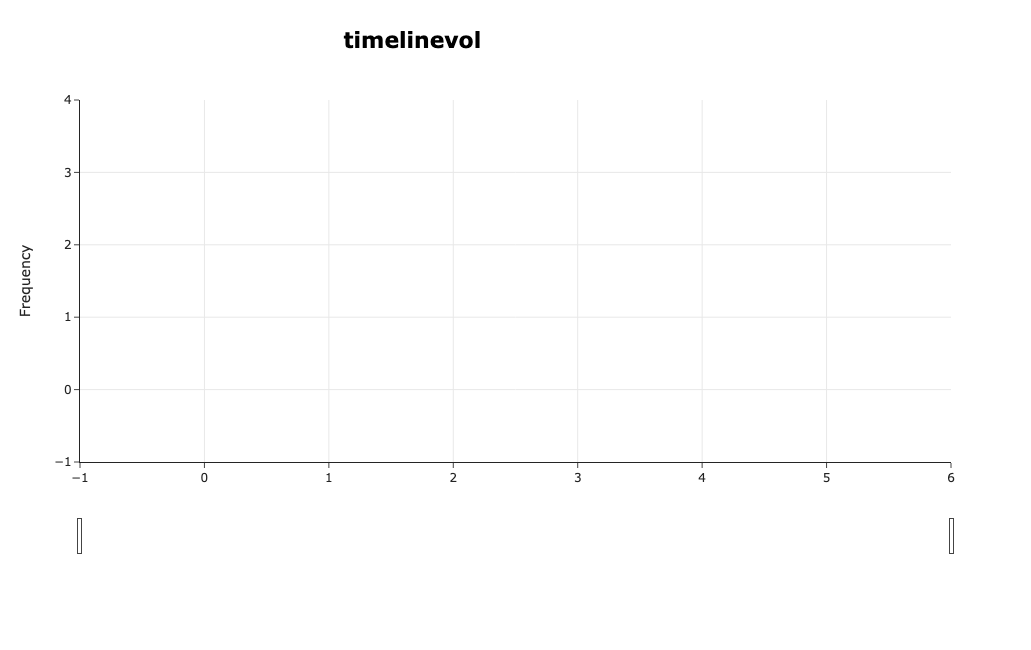

In [51]:
plot_timeseries(df.query(f"iso3=='KEN'"), smooth_x=1, show_infl=True, show_peaks=True)

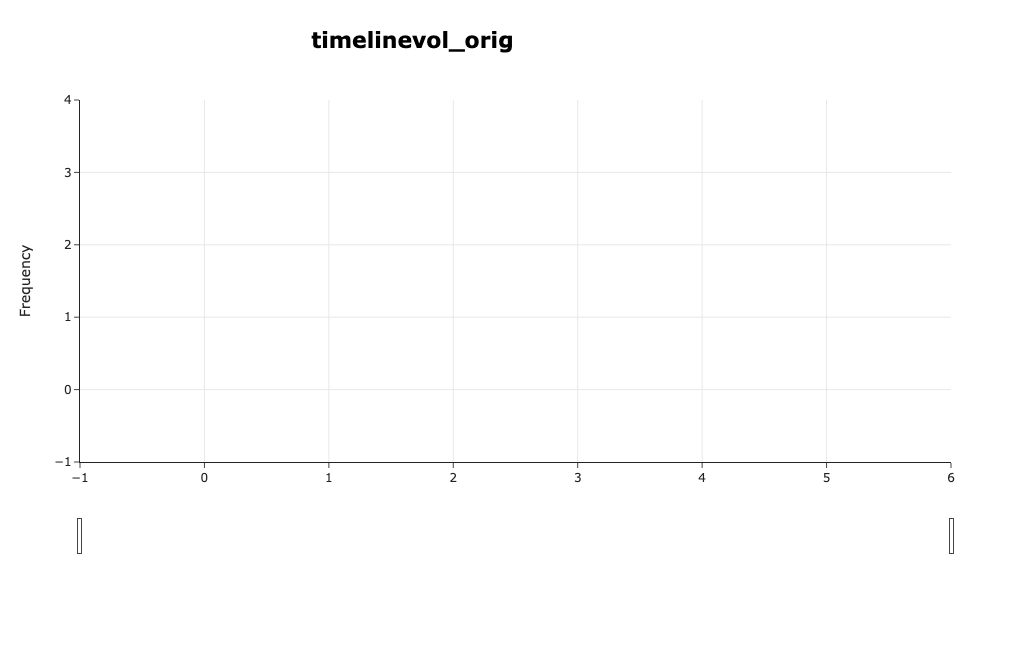

In [52]:
plot_timeseries(df.query(f"iso3=='KEN'"), colname='timelinevol_orig', smooth_x=None, )

In [53]:
# NOTE some dependencies may be missing
# https://github.com/rasbt/watermark/issues/74
%load_ext watermark
%watermark -u -i -m -v -iv --author ewheeler@unicef.org

Author: ewheeler@unicef.org

Last updated: 2023-11-05T19:45:19.877648+03:00

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.12.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 21.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

numpy     : 1.24.1
seaborn   : 0.12.2
joblib    : 1.3.2
pandas    : 2.1.1
matplotlib: 3.6.3
plotly    : 5.14.1

